In [1]:
!nvidia-smi

Fri Mar  1 13:46:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   29C    P8              22W / 215W |    322MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
data_dir = '../data/data_preprocessed/esd/features_4balanced/'

sr = 16000

data_x = np.load(f'{data_dir}esd.audio16k.npy', 
                 allow_pickle=True)
data_y = np.load(f'{data_dir}esd.label_emotion.npy', 
                 allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 22400
Test: 5600


In [8]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [9]:
labels = ['ang', 'neu', 'sad', 'hap']
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [10]:
import traceback
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13mfcc.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 40, 'n_fft': 512, 'hop_length': 128, 'n_mels': 64, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [11]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [12]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [13]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                       | 0.001142857142857143/10 [00:00<1:24:11, 505.25s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.597154
Mem before-during-after: 1226752 9887232 21712384


  0%|▎                                                                                                        | 0.023999999999999983/10 [00:06<42:52, 257.85s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.344232
Mem before-during-after: 21712384 21852160 21712384


  0%|▍                                                                                                        | 0.046285714285714215/10 [00:12<42:25, 255.72s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.462362
Mem before-during-after: 21712384 21852160 21712384


  1%|▋                                                                                                         | 0.06971428571428559/10 [00:18<46:05, 278.47s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 1.231245
Mem before-during-after: 21712384 21852160 21712384


  1%|▉                                                                                                         | 0.09257142857142839/10 [00:25<44:37, 270.23s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.355483
Mem before-during-after: 21712384 21852160 21712384


  1%|█▏                                                                                                        | 0.11542857142857119/10 [00:31<44:53, 272.51s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 1.130401
Mem before-during-after: 21712384 21852160 21712384


  1%|█▍                                                                                                        | 0.13828571428571432/10 [00:37<44:10, 268.77s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.054540
Mem before-during-after: 21712384 21852160 21712384


  2%|█▋                                                                                                        | 0.16114285714285767/10 [00:43<43:12, 263.48s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 0.965139
Mem before-during-after: 21712384 21852160 21712384


  2%|█▉                                                                                                        | 0.18400000000000102/10 [00:49<41:42, 254.97s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 1.018991
Mem before-during-after: 21712384 21852160 21712384


  2%|██▏                                                                                                       | 0.20685714285714438/10 [00:55<42:25, 259.93s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 0.950468
Mem before-during-after: 21712384 21852160 21712384


  2%|██▍                                                                                                       | 0.22971428571428773/10 [01:01<42:43, 262.36s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 1.057405
Mem before-during-after: 21712384 21852160 21712384


  3%|██▋                                                                                                       | 0.25257142857143094/10 [01:08<43:33, 268.08s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 1.452343
Mem before-during-after: 21712384 21852160 21712384


  3%|██▉                                                                                                        | 0.2754285714285732/10 [01:14<42:57, 265.07s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 1.368638
Mem before-during-after: 21712384 21852160 21712384


  3%|███▏                                                                                                      | 0.29828571428571543/10 [01:20<43:52, 271.31s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 0.860218
Mem before-during-after: 21712384 21852160 21712384


  3%|███▍                                                                                                       | 0.3211428571428577/10 [01:26<41:22, 256.45s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: 1.681261
Mem before-during-after: 21712384 21852160 21712384


  3%|███▋                                                                                                       | 0.3439999999999999/10 [01:32<41:35, 258.41s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: 0.980512
Mem before-during-after: 21712384 21852160 21712384


  4%|███▉                                                                                                      | 0.36685714285714216/10 [01:38<42:37, 265.50s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: 1.088319
Mem before-during-after: 21712384 21852160 21712384


  4%|████▏                                                                                                      | 0.3897142857142844/10 [01:44<42:32, 265.55s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: 1.080753
Mem before-during-after: 21712384 21852160 21712384


  4%|████▎                                                                                                     | 0.41257142857142665/10 [01:50<43:16, 270.86s/it]

Train Epoch: 1 [11520/22400 (51%)]	Loss: 0.965254
Mem before-during-after: 21712384 21852160 21712384


  4%|████▋                                                                                                      | 0.4354285714285689/10 [01:57<41:35, 260.87s/it]

Train Epoch: 1 [12160/22400 (54%)]	Loss: 0.868609
Mem before-during-after: 21712384 21852160 21712384


  5%|████▊                                                                                                     | 0.45828571428571113/10 [02:03<41:43, 262.40s/it]

Train Epoch: 1 [12800/22400 (57%)]	Loss: 0.872969
Mem before-during-after: 21712384 21852160 21712384


  5%|█████▏                                                                                                     | 0.4811428571428534/10 [02:09<41:38, 262.48s/it]

Train Epoch: 1 [13440/22400 (60%)]	Loss: 1.056390
Mem before-during-after: 21712384 21852160 21712384


  5%|█████▍                                                                                                     | 0.5039999999999957/10 [02:15<41:43, 263.66s/it]

Train Epoch: 1 [14080/22400 (63%)]	Loss: 1.056141
Mem before-during-after: 21712384 21852160 21712384


  5%|█████▋                                                                                                     | 0.5268571428571379/10 [02:21<42:06, 266.71s/it]

Train Epoch: 1 [14720/22400 (66%)]	Loss: 1.038865
Mem before-during-after: 21712384 21852160 21712384


  5%|█████▉                                                                                                     | 0.5497142857142802/10 [02:27<41:16, 262.06s/it]

Train Epoch: 1 [15360/22400 (69%)]	Loss: 0.738310
Mem before-during-after: 21712384 21852160 21712384


  6%|██████▏                                                                                                    | 0.5725714285714224/10 [02:33<42:03, 267.63s/it]

Train Epoch: 1 [16000/22400 (71%)]	Loss: 0.833405
Mem before-during-after: 21712384 21852160 21712384


  6%|██████▎                                                                                                    | 0.5954285714285646/10 [02:39<42:28, 270.93s/it]

Train Epoch: 1 [16640/22400 (74%)]	Loss: 0.741377
Mem before-during-after: 21712384 21852160 21712384


  6%|██████▌                                                                                                    | 0.6182857142857069/10 [02:46<41:32, 265.64s/it]

Train Epoch: 1 [17280/22400 (77%)]	Loss: 0.668216
Mem before-during-after: 21712384 21852160 21712384


  6%|██████▊                                                                                                    | 0.6411428571428491/10 [02:52<40:53, 262.11s/it]

Train Epoch: 1 [17920/22400 (80%)]	Loss: 0.688198
Mem before-during-after: 21712384 21852160 21712384


  7%|███████                                                                                                    | 0.6639999999999914/10 [02:58<41:26, 266.36s/it]

Train Epoch: 1 [18560/22400 (83%)]	Loss: 0.943008
Mem before-during-after: 21712384 21852160 21712384


  7%|███████▎                                                                                                   | 0.6868571428571336/10 [03:04<39:53, 256.99s/it]

Train Epoch: 1 [19200/22400 (86%)]	Loss: 0.913139
Mem before-during-after: 21712384 21852160 21712384


  7%|███████▌                                                                                                   | 0.7097142857142759/10 [03:10<41:17, 266.69s/it]

Train Epoch: 1 [19840/22400 (89%)]	Loss: 0.950548
Mem before-during-after: 21712384 21852160 21712384


  7%|███████▊                                                                                                   | 0.7325714285714181/10 [03:16<41:43, 270.14s/it]

Train Epoch: 1 [20480/22400 (91%)]	Loss: 0.720686
Mem before-during-after: 21712384 21852160 21712384


  8%|████████                                                                                                   | 0.7554285714285603/10 [03:22<40:09, 260.66s/it]

Train Epoch: 1 [21120/22400 (94%)]	Loss: 0.924667
Mem before-during-after: 21712384 21852160 21712384


  8%|████████▎                                                                                                  | 0.7782857142857026/10 [03:29<41:22, 269.15s/it]

Train Epoch: 1 [21760/22400 (97%)]	Loss: 0.982250
Mem before-during-after: 21712384 21852160 21712384


 10%|██████████▊                                                                                                 | 1.000571428571411/10 [04:28<38:40, 257.88s/it]


Test Epoch: 1	Accuracy: 3597/5600 (64%)

Train Epoch: 2 [0/22400 (0%)]	Loss: 0.504272
Mem before-during-after: 21711360 21852160 21712384


 10%|██████████▉                                                                                                | 1.0239999999999863/10 [04:34<40:19, 269.56s/it]

Train Epoch: 2 [640/22400 (3%)]	Loss: 0.989050
Mem before-during-after: 21712384 21852160 21712384


 10%|███████████▎                                                                                                | 1.046857142857133/10 [04:40<41:55, 281.00s/it]

Train Epoch: 2 [1280/22400 (6%)]	Loss: 0.717309
Mem before-during-after: 21712384 21852160 21712384


 11%|███████████▍                                                                                               | 1.0697142857142796/10 [04:46<39:58, 268.62s/it]

Train Epoch: 2 [1920/22400 (9%)]	Loss: 0.704490
Mem before-during-after: 21712384 21852160 21712384


 11%|███████████▋                                                                                               | 1.0925714285714263/10 [04:52<39:15, 264.46s/it]

Train Epoch: 2 [2560/22400 (11%)]	Loss: 0.602844
Mem before-during-after: 21712384 21852160 21712384


 11%|████████████                                                                                                | 1.115428571428573/10 [04:59<39:53, 269.44s/it]

Train Epoch: 2 [3200/22400 (14%)]	Loss: 0.616111
Mem before-during-after: 21712384 21852160 21712384


 11%|████████████▏                                                                                              | 1.1382857142857197/10 [05:05<38:18, 259.34s/it]

Train Epoch: 2 [3840/22400 (17%)]	Loss: 0.688020
Mem before-during-after: 21712384 21852160 21712384


 12%|████████████▍                                                                                              | 1.1611428571428664/10 [05:11<37:52, 257.15s/it]

Train Epoch: 2 [4480/22400 (20%)]	Loss: 0.592431
Mem before-during-after: 21712384 21852160 21712384


 12%|████████████▊                                                                                               | 1.184000000000013/10 [05:17<40:19, 274.49s/it]

Train Epoch: 2 [5120/22400 (23%)]	Loss: 0.730655
Mem before-during-after: 21712384 21852160 21712384


 12%|████████████▉                                                                                              | 1.2068571428571597/10 [05:23<39:24, 268.94s/it]

Train Epoch: 2 [5760/22400 (26%)]	Loss: 1.507449
Mem before-during-after: 21712384 21852160 21712384


 12%|█████████████▏                                                                                             | 1.2297142857143064/10 [05:29<38:59, 266.71s/it]

Train Epoch: 2 [6400/22400 (29%)]	Loss: 0.962402
Mem before-during-after: 21712384 21852160 21712384


 13%|█████████████▌                                                                                              | 1.252571428571453/10 [05:35<40:42, 279.24s/it]

Train Epoch: 2 [7040/22400 (31%)]	Loss: 0.705016
Mem before-during-after: 21712384 21852160 21712384


 13%|█████████████▋                                                                                             | 1.2754285714285998/10 [05:42<40:34, 279.05s/it]

Train Epoch: 2 [7680/22400 (34%)]	Loss: 0.498439
Mem before-during-after: 21712384 21852160 21712384


 13%|█████████████▉                                                                                             | 1.2982857142857465/10 [05:48<37:18, 257.28s/it]

Train Epoch: 2 [8320/22400 (37%)]	Loss: 0.980152
Mem before-during-after: 21712384 21852160 21712384


 13%|██████████████▏                                                                                            | 1.3211428571428931/10 [05:54<39:52, 275.67s/it]

Train Epoch: 2 [8960/22400 (40%)]	Loss: 1.066170
Mem before-during-after: 21712384 21852160 21712384


 13%|██████████████▍                                                                                            | 1.3440000000000398/10 [06:00<38:36, 267.64s/it]

Train Epoch: 2 [9600/22400 (43%)]	Loss: 0.452596
Mem before-during-after: 21712384 21852160 21712384


 14%|██████████████▋                                                                                            | 1.3668571428571865/10 [06:06<37:31, 260.83s/it]

Train Epoch: 2 [10240/22400 (46%)]	Loss: 0.825751
Mem before-during-after: 21712384 21852160 21712384


 14%|██████████████▊                                                                                            | 1.3897142857143332/10 [06:12<37:44, 262.99s/it]

Train Epoch: 2 [10880/22400 (49%)]	Loss: 0.865931
Mem before-during-after: 21712384 21852160 21712384


 14%|███████████████                                                                                            | 1.4125714285714799/10 [06:18<37:22, 261.13s/it]

Train Epoch: 2 [11520/22400 (51%)]	Loss: 0.898826
Mem before-during-after: 21712384 21852160 21712384


 14%|███████████████▎                                                                                           | 1.4354285714286266/10 [06:24<39:12, 274.64s/it]

Train Epoch: 2 [12160/22400 (54%)]	Loss: 0.808927
Mem before-during-after: 21712384 21852160 21712384


 15%|███████████████▌                                                                                           | 1.4582857142857732/10 [06:30<39:07, 274.80s/it]

Train Epoch: 2 [12800/22400 (57%)]	Loss: 0.718051
Mem before-during-after: 21712384 21852160 21712384


 15%|████████████████▏                                                                                            | 1.48114285714292/10 [06:36<39:37, 279.05s/it]

Train Epoch: 2 [13440/22400 (60%)]	Loss: 0.672460
Mem before-during-after: 21712384 21852160 21712384


 15%|████████████████                                                                                           | 1.5040000000000666/10 [06:43<36:48, 259.96s/it]

Train Epoch: 2 [14080/22400 (63%)]	Loss: 0.671422
Mem before-during-after: 21712384 21852160 21712384


 15%|████████████████▎                                                                                          | 1.5268571428572133/10 [06:49<39:15, 277.97s/it]

Train Epoch: 2 [14720/22400 (66%)]	Loss: 0.756077
Mem before-during-after: 21712384 21852160 21712384


 15%|████████████████▉                                                                                            | 1.54971428571436/10 [06:55<37:37, 267.21s/it]

Train Epoch: 2 [15360/22400 (69%)]	Loss: 0.874926
Mem before-during-after: 21712384 21852160 21712384


 16%|████████████████▊                                                                                          | 1.5725714285715067/10 [07:01<37:38, 267.96s/it]

Train Epoch: 2 [16000/22400 (71%)]	Loss: 0.503001
Mem before-during-after: 21712384 21852160 21712384


 16%|█████████████████                                                                                          | 1.5954285714286534/10 [07:07<36:35, 261.25s/it]

Train Epoch: 2 [16640/22400 (74%)]	Loss: 0.364466
Mem before-during-after: 21712384 21852160 21712384


 16%|█████████████████▊                                                                                            | 1.6182857142858/10 [07:13<37:06, 265.67s/it]

Train Epoch: 2 [17280/22400 (77%)]	Loss: 0.447932
Mem before-during-after: 21712384 21852160 21712384


 16%|█████████████████▌                                                                                         | 1.6411428571429467/10 [07:19<37:13, 267.18s/it]

Train Epoch: 2 [17920/22400 (80%)]	Loss: 0.954564
Mem before-during-after: 21712384 21852160 21712384


 17%|█████████████████▊                                                                                         | 1.6640000000000934/10 [07:25<35:58, 258.93s/it]

Train Epoch: 2 [18560/22400 (83%)]	Loss: 0.848769
Mem before-during-after: 21712384 21852160 21712384


 17%|██████████████████▍                                                                                          | 1.68685714285724/10 [07:31<37:30, 270.73s/it]

Train Epoch: 2 [19200/22400 (86%)]	Loss: 0.517118
Mem before-during-after: 21712384 21852160 21712384


 17%|██████████████████▎                                                                                        | 1.7097142857143868/10 [07:38<36:37, 265.12s/it]

Train Epoch: 2 [19840/22400 (89%)]	Loss: 0.817259
Mem before-during-after: 21712384 21852160 21712384


 17%|██████████████████▌                                                                                        | 1.7325714285715335/10 [07:44<37:48, 274.38s/it]

Train Epoch: 2 [20480/22400 (91%)]	Loss: 0.399837
Mem before-during-after: 21712384 21852160 21712384


 18%|██████████████████▊                                                                                        | 1.7554285714286801/10 [07:50<35:49, 260.74s/it]

Train Epoch: 2 [21120/22400 (94%)]	Loss: 0.501151
Mem before-during-after: 21712384 21852160 21712384


 18%|███████████████████                                                                                        | 1.7782857142858268/10 [07:56<38:02, 277.61s/it]

Train Epoch: 2 [21760/22400 (97%)]	Loss: 0.328778
Mem before-during-after: 21712384 21852160 21712384


 20%|█████████████████████▌                                                                                      | 2.000571428571578/10 [08:55<37:30, 281.31s/it]


Test Epoch: 2	Accuracy: 4033/5600 (72%)

Train Epoch: 3 [0/22400 (0%)]	Loss: 0.506778
Mem before-during-after: 21711360 21852160 21712384


 20%|█████████████████████▋                                                                                     | 2.0240000000001444/10 [09:01<34:51, 262.21s/it]

Train Epoch: 3 [640/22400 (3%)]	Loss: 0.694007
Mem before-during-after: 21712384 21852160 21712384


 20%|██████████████████████                                                                                      | 2.046857142857282/10 [09:07<34:48, 262.64s/it]

Train Epoch: 3 [1280/22400 (6%)]	Loss: 0.759243
Mem before-during-after: 21712384 21852160 21712384


 21%|██████████████████████▌                                                                                      | 2.06971428571442/10 [09:13<34:31, 261.27s/it]

Train Epoch: 3 [1920/22400 (9%)]	Loss: 0.744214
Mem before-during-after: 21712384 21852160 21712384


 21%|██████████████████████▍                                                                                    | 2.0925714285715578/10 [09:19<34:45, 263.74s/it]

Train Epoch: 3 [2560/22400 (11%)]	Loss: 0.443794
Mem before-during-after: 21712384 21852160 21712384


 21%|██████████████████████▋                                                                                    | 2.1154285714286956/10 [09:25<34:08, 259.79s/it]

Train Epoch: 3 [3200/22400 (14%)]	Loss: 0.748848
Mem before-during-after: 21712384 21852160 21712384


 21%|██████████████████████▉                                                                                    | 2.1382857142858334/10 [09:32<34:22, 262.32s/it]

Train Epoch: 3 [3840/22400 (17%)]	Loss: 0.477233
Mem before-during-after: 21712384 21852160 21712384


 22%|███████████████████████▎                                                                                    | 2.161142857142971/10 [09:38<33:55, 259.62s/it]

Train Epoch: 3 [4480/22400 (20%)]	Loss: 1.214976
Mem before-during-after: 21712384 21852160 21712384


 22%|███████████████████████▌                                                                                    | 2.184000000000109/10 [09:44<34:44, 266.64s/it]

Train Epoch: 3 [5120/22400 (23%)]	Loss: 0.304519
Mem before-during-after: 21712384 21852160 21712384


 22%|███████████████████████▌                                                                                   | 2.2068571428572468/10 [09:50<33:42, 259.51s/it]

Train Epoch: 3 [5760/22400 (26%)]	Loss: 0.548511
Mem before-during-after: 21712384 21852160 21712384


 22%|███████████████████████▊                                                                                   | 2.2297142857143846/10 [09:56<35:45, 276.11s/it]

Train Epoch: 3 [6400/22400 (29%)]	Loss: 0.351192
Mem before-during-after: 21712384 21852160 21712384


 23%|████████████████████████                                                                                   | 2.2525714285715224/10 [10:02<34:52, 270.08s/it]

Train Epoch: 3 [7040/22400 (31%)]	Loss: 0.093074
Mem before-during-after: 21712384 21852160 21712384


 23%|████████████████████████▊                                                                                    | 2.27542857142866/10 [10:08<35:42, 277.37s/it]

Train Epoch: 3 [7680/22400 (34%)]	Loss: 0.739190
Mem before-during-after: 21712384 21852160 21712384


 23%|████████████████████████▊                                                                                   | 2.298285714285798/10 [10:14<33:08, 258.15s/it]

Train Epoch: 3 [8320/22400 (37%)]	Loss: 0.629762
Mem before-during-after: 21712384 21852160 21712384


 23%|█████████████████████████                                                                                   | 2.321142857142936/10 [10:20<33:00, 257.90s/it]

Train Epoch: 3 [8960/22400 (40%)]	Loss: 0.364486
Mem before-during-after: 21712384 21852160 21712384


 23%|█████████████████████████                                                                                  | 2.3440000000000736/10 [10:26<35:09, 275.53s/it]

Train Epoch: 3 [9600/22400 (43%)]	Loss: 0.310046
Mem before-during-after: 21712384 21852160 21712384


 24%|█████████████████████████▎                                                                                 | 2.3668571428572114/10 [10:33<34:41, 272.65s/it]

Train Epoch: 3 [10240/22400 (46%)]	Loss: 0.200392
Mem before-during-after: 21712384 21852160 21712384


 24%|█████████████████████████▊                                                                                  | 2.389714285714349/10 [10:39<34:21, 270.93s/it]

Train Epoch: 3 [10880/22400 (49%)]	Loss: 0.244855
Mem before-during-after: 21712384 21852160 21712384


 24%|██████████████████████████                                                                                  | 2.412571428571487/10 [10:45<33:12, 262.57s/it]

Train Epoch: 3 [11520/22400 (51%)]	Loss: 0.609457
Mem before-during-after: 21712384 21852160 21712384


 24%|██████████████████████████▎                                                                                 | 2.435428571428625/10 [10:51<35:10, 278.97s/it]

Train Epoch: 3 [12160/22400 (54%)]	Loss: 0.203030
Mem before-during-after: 21712384 21852160 21712384


 25%|██████████████████████████▎                                                                                | 2.4582857142857626/10 [10:57<33:52, 269.56s/it]

Train Epoch: 3 [12800/22400 (57%)]	Loss: 0.644567
Mem before-during-after: 21712384 21852160 21712384


 25%|██████████████████████████▌                                                                                | 2.4811428571429004/10 [11:03<33:03, 263.85s/it]

Train Epoch: 3 [13440/22400 (60%)]	Loss: 0.360473
Mem before-during-after: 21712384 21852160 21712384


 25%|███████████████████████████                                                                                 | 2.504000000000038/10 [11:10<32:50, 262.91s/it]

Train Epoch: 3 [14080/22400 (63%)]	Loss: 1.124053
Mem before-during-after: 21712384 21852160 21712384


 25%|███████████████████████████▎                                                                                | 2.526857142857176/10 [11:16<34:30, 277.11s/it]

Train Epoch: 3 [14720/22400 (66%)]	Loss: 0.506209
Mem before-during-after: 21712384 21852160 21712384


 25%|███████████████████████████▌                                                                                | 2.549714285714314/10 [11:22<33:59, 273.75s/it]

Train Epoch: 3 [15360/22400 (69%)]	Loss: 0.983833
Mem before-during-after: 21712384 21852160 21712384


 26%|███████████████████████████▌                                                                               | 2.5725714285714516/10 [11:28<33:17, 268.97s/it]

Train Epoch: 3 [16000/22400 (71%)]	Loss: 0.426353
Mem before-during-after: 21712384 21852160 21712384


 26%|███████████████████████████▊                                                                               | 2.5954285714285894/10 [11:34<33:45, 273.58s/it]

Train Epoch: 3 [16640/22400 (74%)]	Loss: 0.616285
Mem before-during-after: 21712384 21852160 21712384


 26%|████████████████████████████▎                                                                               | 2.618285714285727/10 [11:40<33:51, 275.15s/it]

Train Epoch: 3 [17280/22400 (77%)]	Loss: 0.329479
Mem before-during-after: 21712384 21852160 21712384


 26%|████████████████████████████▌                                                                               | 2.641142857142865/10 [11:46<31:41, 258.42s/it]

Train Epoch: 3 [17920/22400 (80%)]	Loss: 0.384165
Mem before-during-after: 21712384 21852160 21712384


 27%|████████████████████████████▊                                                                               | 2.664000000000003/10 [11:53<32:45, 267.89s/it]

Train Epoch: 3 [18560/22400 (83%)]	Loss: 0.446404
Mem before-during-after: 21712384 21852160 21712384


 27%|████████████████████████████▋                                                                              | 2.6868571428571406/10 [11:59<33:47, 277.18s/it]

Train Epoch: 3 [19200/22400 (86%)]	Loss: 0.571961
Mem before-during-after: 21712384 21852160 21712384


 27%|████████████████████████████▉                                                                              | 2.7097142857142784/10 [12:05<31:35, 260.01s/it]

Train Epoch: 3 [19840/22400 (89%)]	Loss: 0.877851
Mem before-during-after: 21712384 21852160 21712384


 27%|█████████████████████████████▌                                                                              | 2.732571428571416/10 [12:11<32:04, 264.75s/it]

Train Epoch: 3 [20480/22400 (91%)]	Loss: 0.354597
Mem before-during-after: 21712384 21852160 21712384


 28%|█████████████████████████████▊                                                                              | 2.755428571428554/10 [12:17<32:59, 273.22s/it]

Train Epoch: 3 [21120/22400 (94%)]	Loss: 0.347013
Mem before-during-after: 21712384 21852160 21712384


 28%|██████████████████████████████                                                                              | 2.778285714285692/10 [12:23<32:00, 265.94s/it]

Train Epoch: 3 [21760/22400 (97%)]	Loss: 0.900884
Mem before-during-after: 21712384 21852160 21712384


 30%|████████████████████████████████▍                                                                           | 3.000571428571357/10 [13:23<30:25, 260.75s/it]


Test Epoch: 3	Accuracy: 4503/5600 (80%)

Train Epoch: 4 [0/22400 (0%)]	Loss: 0.311866
Mem before-during-after: 21711360 21852160 21712384


 30%|████████████████████████████████▋                                                                           | 3.023999999999923/10 [13:29<30:55, 265.99s/it]

Train Epoch: 4 [640/22400 (3%)]	Loss: 0.360512
Mem before-during-after: 21712384 21852160 21712384


 30%|████████████████████████████████▉                                                                           | 3.046857142857061/10 [13:35<32:22, 279.42s/it]

Train Epoch: 4 [1280/22400 (6%)]	Loss: 0.612707
Mem before-during-after: 21712384 21852160 21712384


 31%|█████████████████████████████████▏                                                                          | 3.069714285714199/10 [13:41<30:36, 265.03s/it]

Train Epoch: 4 [1920/22400 (9%)]	Loss: 0.835466
Mem before-during-after: 21712384 21852160 21712384


 31%|█████████████████████████████████                                                                          | 3.0925714285713366/10 [13:47<30:05, 261.40s/it]

Train Epoch: 4 [2560/22400 (11%)]	Loss: 0.341630
Mem before-during-after: 21712384 21852160 21712384


 31%|█████████████████████████████████▎                                                                         | 3.1154285714284744/10 [13:53<29:17, 255.21s/it]

Train Epoch: 4 [3200/22400 (14%)]	Loss: 0.537740
Mem before-during-after: 21712384 21852160 21712384


 31%|█████████████████████████████████▉                                                                          | 3.138285714285612/10 [13:59<29:21, 256.76s/it]

Train Epoch: 4 [3840/22400 (17%)]	Loss: 0.653202
Mem before-during-after: 21712384 21852160 21712384


 32%|██████████████████████████████████▍                                                                          | 3.16114285714275/10 [14:06<37:16, 326.96s/it]

Train Epoch: 4 [4480/22400 (20%)]	Loss: 0.640910
Mem before-during-after: 21712384 21852160 21712384


 32%|██████████████████████████████████▍                                                                         | 3.183999999999888/10 [14:12<29:02, 255.63s/it]

Train Epoch: 4 [5120/22400 (23%)]	Loss: 1.054513
Mem before-during-after: 21712384 21852160 21712384


 32%|██████████████████████████████████▎                                                                        | 3.2068571428570256/10 [14:18<28:59, 256.14s/it]

Train Epoch: 4 [5760/22400 (26%)]	Loss: 0.463778
Mem before-during-after: 21712384 21852160 21712384


 32%|██████████████████████████████████▌                                                                        | 3.2297142857141634/10 [14:24<28:55, 256.35s/it]

Train Epoch: 4 [6400/22400 (29%)]	Loss: 0.462570
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████████████████████████████▏                                                                        | 3.252571428571301/10 [14:30<28:53, 256.94s/it]

Train Epoch: 4 [7040/22400 (31%)]	Loss: 0.625434
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████████████████████████████▎                                                                        | 3.275428571428439/10 [14:36<28:40, 255.80s/it]

Train Epoch: 4 [7680/22400 (34%)]	Loss: 0.359934
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████████████████████████████▌                                                                        | 3.298285714285577/10 [14:42<28:00, 250.68s/it]

Train Epoch: 4 [8320/22400 (37%)]	Loss: 0.146133
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████████████████████████████▌                                                                       | 3.3211428571427146/10 [14:48<28:44, 258.14s/it]

Train Epoch: 4 [8960/22400 (40%)]	Loss: 0.085173
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████████████████████████████▊                                                                       | 3.3439999999998524/10 [14:54<29:31, 266.18s/it]

Train Epoch: 4 [9600/22400 (43%)]	Loss: 0.377244
Mem before-during-after: 21712384 21852160 21712384


 34%|████████████████████████████████████                                                                       | 3.3668571428569902/10 [14:59<28:23, 256.75s/it]

Train Epoch: 4 [10240/22400 (46%)]	Loss: 0.594058
Mem before-during-after: 21712384 21852160 21712384


 34%|████████████████████████████████████▌                                                                       | 3.389714285714128/10 [15:05<28:32, 259.09s/it]

Train Epoch: 4 [10880/22400 (49%)]	Loss: 0.934955
Mem before-during-after: 21712384 21852160 21712384


 34%|████████████████████████████████████▊                                                                       | 3.412571428571266/10 [15:11<28:24, 258.81s/it]

Train Epoch: 4 [11520/22400 (51%)]	Loss: 0.381085
Mem before-during-after: 21712384 21852160 21712384


 34%|████████████████████████████████████▊                                                                      | 3.4354285714284036/10 [15:17<28:54, 264.16s/it]

Train Epoch: 4 [12160/22400 (54%)]	Loss: 0.232236
Mem before-during-after: 21712384 21852160 21712384


 35%|█████████████████████████████████████                                                                      | 3.4582857142855414/10 [15:23<28:05, 257.71s/it]

Train Epoch: 4 [12800/22400 (57%)]	Loss: 0.381893
Mem before-during-after: 21712384 21852160 21712384


 35%|█████████████████████████████████████▏                                                                     | 3.4811428571426792/10 [15:29<27:36, 254.06s/it]

Train Epoch: 4 [13440/22400 (60%)]	Loss: 0.342960
Mem before-during-after: 21712384 21852160 21712384


 35%|█████████████████████████████████████▊                                                                      | 3.503999999999817/10 [15:35<27:29, 254.00s/it]

Train Epoch: 4 [14080/22400 (63%)]	Loss: 0.378309
Mem before-during-after: 21712384 21852160 21712384


 35%|██████████████████████████████████████                                                                      | 3.526857142856955/10 [15:41<28:19, 262.62s/it]

Train Epoch: 4 [14720/22400 (66%)]	Loss: 0.248625
Mem before-during-after: 21712384 21852160 21712384


 35%|█████████████████████████████████████▉                                                                     | 3.5497142857140926/10 [15:47<28:11, 262.20s/it]

Train Epoch: 4 [15360/22400 (69%)]	Loss: 0.454568
Mem before-during-after: 21712384 21852160 21712384


 36%|██████████████████████████████████████▏                                                                    | 3.5725714285712304/10 [15:53<27:47, 259.43s/it]

Train Epoch: 4 [16000/22400 (71%)]	Loss: 0.306280
Mem before-during-after: 21712384 21852160 21712384


 36%|██████████████████████████████████████▍                                                                    | 3.5954285714283682/10 [15:59<26:55, 252.18s/it]

Train Epoch: 4 [16640/22400 (74%)]	Loss: 0.566106
Mem before-during-after: 21712384 21852160 21712384


 36%|███████████████████████████████████████                                                                     | 3.618285714285506/10 [16:05<27:55, 262.50s/it]

Train Epoch: 4 [17280/22400 (77%)]	Loss: 0.478935
Mem before-during-after: 21712384 21852160 21712384


 36%|███████████████████████████████████████▎                                                                    | 3.641142857142644/10 [16:10<27:13, 256.81s/it]

Train Epoch: 4 [17920/22400 (80%)]	Loss: 0.305057
Mem before-during-after: 21712384 21852160 21712384


 37%|███████████████████████████████████████▏                                                                   | 3.6639999999997817/10 [16:16<27:21, 259.13s/it]

Train Epoch: 4 [18560/22400 (83%)]	Loss: 0.209802
Mem before-during-after: 21712384 21852160 21712384


 37%|███████████████████████████████████████▍                                                                   | 3.6868571428569195/10 [16:22<27:09, 258.16s/it]

Train Epoch: 4 [19200/22400 (86%)]	Loss: 0.991636
Mem before-during-after: 21712384 21852160 21712384


 37%|███████████████████████████████████████▋                                                                   | 3.7097142857140573/10 [16:28<26:27, 252.36s/it]

Train Epoch: 4 [19840/22400 (89%)]	Loss: 0.649874
Mem before-during-after: 21712384 21852160 21712384


 37%|████████████████████████████████████████▎                                                                   | 3.732571428571195/10 [16:34<26:53, 257.49s/it]

Train Epoch: 4 [20480/22400 (91%)]	Loss: 0.563804
Mem before-during-after: 21712384 21852160 21712384


 38%|████████████████████████████████████████▌                                                                   | 3.755428571428333/10 [16:40<27:15, 261.85s/it]

Train Epoch: 4 [21120/22400 (94%)]	Loss: 0.855905
Mem before-during-after: 21712384 21852160 21712384


 38%|████████████████████████████████████████▍                                                                  | 3.7782857142854707/10 [16:46<26:59, 260.31s/it]

Train Epoch: 4 [21760/22400 (97%)]	Loss: 0.481858
Mem before-during-after: 21712384 21852160 21712384


 40%|███████████████████████████████████████████▏                                                                | 4.000571428571136/10 [17:43<25:40, 256.71s/it]


Test Epoch: 4	Accuracy: 4750/5600 (85%)

Train Epoch: 5 [0/22400 (0%)]	Loss: 0.648528
Mem before-during-after: 21711360 21852160 21712384


 40%|███████████████████████████████████████████▊                                                                 | 4.02399999999972/10 [17:49<25:55, 260.36s/it]

Train Epoch: 5 [640/22400 (3%)]	Loss: 0.547149
Mem before-during-after: 21712384 21852160 21712384


 40%|███████████████████████████████████████████▋                                                                | 4.046857142856876/10 [17:55<25:09, 253.61s/it]

Train Epoch: 5 [1280/22400 (6%)]	Loss: 0.314340
Mem before-during-after: 21712384 21852160 21712384


 41%|███████████████████████████████████████████▉                                                                | 4.069714285714031/10 [18:01<25:37, 259.33s/it]

Train Epoch: 5 [1920/22400 (9%)]	Loss: 0.321558
Mem before-during-after: 21712384 21852160 21712384


 41%|████████████████████████████████████████████▏                                                               | 4.092571428571187/10 [18:07<25:32, 259.41s/it]

Train Epoch: 5 [2560/22400 (11%)]	Loss: 0.560838
Mem before-during-after: 21712384 21852160 21712384


 41%|████████████████████████████████████████████                                                               | 4.1154285714283425/10 [18:13<25:13, 257.15s/it]

Train Epoch: 5 [3200/22400 (14%)]	Loss: 0.191161
Mem before-during-after: 21712384 21852160 21712384


 41%|████████████████████████████████████████████▋                                                               | 4.138285714285498/10 [18:19<24:58, 255.65s/it]

Train Epoch: 5 [3840/22400 (17%)]	Loss: 0.640322
Mem before-during-after: 21712384 21852160 21712384


 42%|████████████████████████████████████████████▉                                                               | 4.161142857142654/10 [18:25<26:08, 268.71s/it]

Train Epoch: 5 [4480/22400 (20%)]	Loss: 0.334752
Mem before-during-after: 21712384 21852160 21712384


 42%|█████████████████████████████████████████████▏                                                              | 4.183999999999809/10 [18:30<26:37, 274.65s/it]

Train Epoch: 5 [5120/22400 (23%)]	Loss: 0.081259
Mem before-during-after: 21712384 21852160 21712384


 42%|█████████████████████████████████████████████▍                                                              | 4.206857142856965/10 [18:36<25:06, 260.04s/it]

Train Epoch: 5 [5760/22400 (26%)]	Loss: 0.070561
Mem before-during-after: 21712384 21852160 21712384


 42%|██████████████████████████████████████████████                                                               | 4.22971428571412/10 [18:42<24:12, 251.72s/it]

Train Epoch: 5 [6400/22400 (29%)]	Loss: 0.194084
Mem before-during-after: 21712384 21852160 21712384


 43%|█████████████████████████████████████████████▉                                                              | 4.252571428571276/10 [18:48<24:42, 257.94s/it]

Train Epoch: 5 [7040/22400 (31%)]	Loss: 0.378909
Mem before-during-after: 21712384 21852160 21712384


 43%|█████████████████████████████████████████████▋                                                             | 4.2754285714284315/10 [18:54<24:37, 258.08s/it]

Train Epoch: 5 [7680/22400 (34%)]	Loss: 0.162711
Mem before-during-after: 21712384 21852160 21712384


 43%|██████████████████████████████████████████████▍                                                             | 4.298285714285587/10 [19:00<23:53, 251.37s/it]

Train Epoch: 5 [8320/22400 (37%)]	Loss: 0.343751
Mem before-during-after: 21712384 21852160 21712384


 43%|██████████████████████████████████████████████▋                                                             | 4.321142857142743/10 [19:06<24:09, 255.29s/it]

Train Epoch: 5 [8960/22400 (40%)]	Loss: 0.154410
Mem before-during-after: 21712384 21852160 21712384


 43%|██████████████████████████████████████████████▉                                                             | 4.343999999999898/10 [19:12<24:17, 257.68s/it]

Train Epoch: 5 [9600/22400 (43%)]	Loss: 0.657787
Mem before-during-after: 21712384 21852160 21712384


 44%|███████████████████████████████████████████████▏                                                            | 4.366857142857054/10 [19:18<24:20, 259.22s/it]

Train Epoch: 5 [10240/22400 (46%)]	Loss: 0.558440
Mem before-during-after: 21712384 21852160 21712384


 44%|███████████████████████████████████████████████▍                                                            | 4.389714285714209/10 [19:24<25:30, 272.88s/it]

Train Epoch: 5 [10880/22400 (49%)]	Loss: 0.479880
Mem before-during-after: 21712384 21852160 21712384


 44%|███████████████████████████████████████████████▋                                                            | 4.412571428571365/10 [19:30<25:30, 273.96s/it]

Train Epoch: 5 [11520/22400 (51%)]	Loss: 0.761966
Mem before-during-after: 21712384 21852160 21712384


 44%|████████████████████████████████████████████████▎                                                            | 4.43542857142852/10 [19:36<23:57, 258.32s/it]

Train Epoch: 5 [12160/22400 (54%)]	Loss: 0.206219
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████████████████████████████████████▏                                                           | 4.458285714285676/10 [19:42<24:08, 261.41s/it]

Train Epoch: 5 [12800/22400 (57%)]	Loss: 0.246579
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████████████████████████████████████▍                                                           | 4.481142857142832/10 [19:47<23:29, 255.43s/it]

Train Epoch: 5 [13440/22400 (60%)]	Loss: 0.526196
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████████████████████████████████████▋                                                           | 4.503999999999987/10 [19:53<23:49, 260.12s/it]

Train Epoch: 5 [14080/22400 (63%)]	Loss: 0.410368
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████████████████████████████████████▉                                                           | 4.526857142857143/10 [19:59<23:42, 259.83s/it]

Train Epoch: 5 [14720/22400 (66%)]	Loss: 0.263436
Mem before-during-after: 21712384 21852160 21712384


 45%|█████████████████████████████████████████████████▏                                                          | 4.549714285714298/10 [20:05<23:08, 254.79s/it]

Train Epoch: 5 [15360/22400 (69%)]	Loss: 0.185933
Mem before-during-after: 21712384 21852160 21712384


 46%|█████████████████████████████████████████████████▍                                                          | 4.572571428571454/10 [20:11<23:54, 264.37s/it]

Train Epoch: 5 [16000/22400 (71%)]	Loss: 0.433644
Mem before-during-after: 21712384 21852160 21712384


 46%|█████████████████████████████████████████████████▋                                                          | 4.595428571428609/10 [20:17<23:52, 265.01s/it]

Train Epoch: 5 [16640/22400 (74%)]	Loss: 0.208349
Mem before-during-after: 21712384 21852160 21712384


 46%|█████████████████████████████████████████████████▉                                                          | 4.618285714285765/10 [20:23<24:55, 277.81s/it]

Train Epoch: 5 [17280/22400 (77%)]	Loss: 0.144803
Mem before-during-after: 21712384 21852160 21712384


 46%|█████████████████████████████████████████████████▋                                                         | 4.6411428571429205/10 [20:29<22:59, 257.49s/it]

Train Epoch: 5 [17920/22400 (80%)]	Loss: 0.312893
Mem before-during-after: 21712384 21852160 21712384


 47%|██████████████████████████████████████████████████▎                                                         | 4.664000000000076/10 [20:35<22:44, 255.78s/it]

Train Epoch: 5 [18560/22400 (83%)]	Loss: 0.226767
Mem before-during-after: 21712384 21852160 21712384


 47%|██████████████████████████████████████████████████▌                                                         | 4.686857142857232/10 [20:41<23:51, 269.43s/it]

Train Epoch: 5 [19200/22400 (86%)]	Loss: 0.067599
Mem before-during-after: 21712384 21852160 21712384


 47%|██████████████████████████████████████████████████▊                                                         | 4.709714285714387/10 [20:47<22:54, 259.78s/it]

Train Epoch: 5 [19840/22400 (89%)]	Loss: 0.902989
Mem before-during-after: 21712384 21852160 21712384


 47%|███████████████████████████████████████████████████                                                         | 4.732571428571543/10 [20:53<22:29, 256.22s/it]

Train Epoch: 5 [20480/22400 (91%)]	Loss: 0.435609
Mem before-during-after: 21712384 21852160 21712384


 48%|███████████████████████████████████████████████████▎                                                        | 4.755428571428698/10 [20:59<22:29, 257.39s/it]

Train Epoch: 5 [21120/22400 (94%)]	Loss: 0.875082
Mem before-during-after: 21712384 21852160 21712384


 48%|███████████████████████████████████████████████████▌                                                        | 4.778285714285854/10 [21:05<22:32, 259.09s/it]

Train Epoch: 5 [21760/22400 (97%)]	Loss: 0.233305
Mem before-during-after: 21712384 21852160 21712384


 50%|██████████████████████████████████████████████████████                                                      | 5.000571428571692/10 [22:02<22:03, 264.80s/it]


Test Epoch: 5	Accuracy: 4833/5600 (86%)

Train Epoch: 6 [0/22400 (0%)]	Loss: 0.217588
Mem before-during-after: 21711360 21852160 21712384


 50%|██████████████████████████████████████████████████████▎                                                     | 5.024000000000276/10 [22:08<21:42, 261.73s/it]

Train Epoch: 6 [640/22400 (3%)]	Loss: 0.309259
Mem before-during-after: 21712384 21852160 21712384


 50%|██████████████████████████████████████████████████████▌                                                     | 5.046857142857432/10 [22:14<21:47, 263.90s/it]

Train Epoch: 6 [1280/22400 (6%)]	Loss: 0.125817
Mem before-during-after: 21712384 21852160 21712384


 51%|██████████████████████████████████████████████████████▊                                                     | 5.069714285714587/10 [22:20<21:02, 256.02s/it]

Train Epoch: 6 [1920/22400 (9%)]	Loss: 0.008548
Mem before-during-after: 21712384 21852160 21712384


 51%|██████████████████████████████████████████████████████▉                                                     | 5.092571428571743/10 [22:26<21:24, 261.79s/it]

Train Epoch: 6 [2560/22400 (11%)]	Loss: 0.329229
Mem before-during-after: 21712384 21852160 21712384


 51%|██████████████████████████████████████████████████████▋                                                    | 5.1154285714288985/10 [22:31<20:39, 253.68s/it]

Train Epoch: 6 [3200/22400 (14%)]	Loss: 0.122134
Mem before-during-after: 21712384 21852160 21712384


 51%|███████████████████████████████████████████████████████▍                                                    | 5.138285714286054/10 [22:37<20:55, 258.20s/it]

Train Epoch: 6 [3840/22400 (17%)]	Loss: 0.148480
Mem before-during-after: 21712384 21852160 21712384


 52%|████████████████████████████████████████████████████████▎                                                    | 5.16114285714321/10 [22:43<21:05, 261.50s/it]

Train Epoch: 6 [4480/22400 (20%)]	Loss: 0.715450
Mem before-during-after: 21712384 21852160 21712384


 52%|███████████████████████████████████████████████████████▉                                                    | 5.184000000000365/10 [22:49<21:26, 267.19s/it]

Train Epoch: 6 [5120/22400 (23%)]	Loss: 0.417366
Mem before-during-after: 21712384 21852160 21712384


 52%|████████████████████████████████████████████████████████▏                                                   | 5.206857142857521/10 [22:55<20:49, 260.72s/it]

Train Epoch: 6 [5760/22400 (26%)]	Loss: 0.297306
Mem before-during-after: 21712384 21852160 21712384


 52%|████████████████████████████████████████████████████████▍                                                   | 5.229714285714676/10 [23:01<20:43, 260.64s/it]

Train Epoch: 6 [6400/22400 (29%)]	Loss: 0.439206
Mem before-during-after: 21712384 21852160 21712384


 53%|████████████████████████████████████████████████████████▋                                                   | 5.252571428571832/10 [23:07<21:14, 268.53s/it]

Train Epoch: 6 [7040/22400 (31%)]	Loss: 0.203403
Mem before-during-after: 21712384 21852160 21712384


 53%|████████████████████████████████████████████████████████▍                                                  | 5.2754285714289875/10 [23:13<20:17, 257.62s/it]

Train Epoch: 6 [7680/22400 (34%)]	Loss: 0.289981
Mem before-during-after: 21712384 21852160 21712384


 53%|█████████████████████████████████████████████████████████▏                                                  | 5.298285714286143/10 [23:19<19:42, 251.41s/it]

Train Epoch: 6 [8320/22400 (37%)]	Loss: 0.669091
Mem before-during-after: 21712384 21852160 21712384


 53%|█████████████████████████████████████████████████████████▍                                                  | 5.321142857143299/10 [23:25<19:59, 256.29s/it]

Train Epoch: 6 [8960/22400 (40%)]	Loss: 0.377681
Mem before-during-after: 21712384 21852160 21712384


 53%|█████████████████████████████████████████████████████████▋                                                  | 5.344000000000454/10 [23:31<19:57, 257.16s/it]

Train Epoch: 6 [9600/22400 (43%)]	Loss: 0.480989
Mem before-during-after: 21712384 21852160 21712384


 54%|██████████████████████████████████████████████████████████▍                                                  | 5.36685714285761/10 [23:37<20:14, 262.12s/it]

Train Epoch: 6 [10240/22400 (46%)]	Loss: 0.238464
Mem before-during-after: 21712384 21852160 21712384


 54%|██████████████████████████████████████████████████████████▏                                                 | 5.389714285714765/10 [23:42<19:54, 259.01s/it]

Train Epoch: 6 [10880/22400 (49%)]	Loss: 0.595568
Mem before-during-after: 21712384 21852160 21712384


 54%|██████████████████████████████████████████████████████████▍                                                 | 5.412571428571921/10 [23:48<20:38, 270.08s/it]

Train Epoch: 6 [11520/22400 (51%)]	Loss: 0.719660
Mem before-during-after: 21712384 21852160 21712384


 54%|██████████████████████████████████████████████████████████▋                                                 | 5.435428571429076/10 [23:55<20:12, 265.69s/it]

Train Epoch: 6 [12160/22400 (54%)]	Loss: 0.428088
Mem before-during-after: 21712384 21852160 21712384


 55%|██████████████████████████████████████████████████████████▉                                                 | 5.458285714286232/10 [24:01<20:53, 276.02s/it]

Train Epoch: 6 [12800/22400 (57%)]	Loss: 0.835604
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████████████████████████████████████████████▏                                                | 5.481142857143388/10 [24:06<20:23, 270.66s/it]

Train Epoch: 6 [13440/22400 (60%)]	Loss: 0.352960
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████████████████████████████████████████████▍                                                | 5.504000000000543/10 [24:12<19:26, 259.35s/it]

Train Epoch: 6 [14080/22400 (63%)]	Loss: 0.277546
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████████████████████████████████████████████▋                                                | 5.526857142857699/10 [24:18<19:26, 260.85s/it]

Train Epoch: 6 [14720/22400 (66%)]	Loss: 0.995326
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████████████████████████████████████████████▉                                                | 5.549714285714854/10 [24:24<19:18, 260.31s/it]

Train Epoch: 6 [15360/22400 (69%)]	Loss: 0.206914
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████████████████████████████████████████████▋                                                | 5.57257142857201/10 [24:30<19:00, 257.68s/it]

Train Epoch: 6 [16000/22400 (71%)]	Loss: 0.490630
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████████████████████████████████████████████▍                                               | 5.595428571429165/10 [24:36<18:51, 256.87s/it]

Train Epoch: 6 [16640/22400 (74%)]	Loss: 0.196049
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████████████████████████████████████████████▋                                               | 5.618285714286321/10 [24:42<18:55, 259.19s/it]

Train Epoch: 6 [17280/22400 (77%)]	Loss: 0.490554
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████████████████████████████████████████████▎                                              | 5.6411428571434765/10 [24:48<19:04, 262.68s/it]

Train Epoch: 6 [17920/22400 (80%)]	Loss: 0.141307
Mem before-during-after: 21712384 21852160 21712384


 57%|█████████████████████████████████████████████████████████████▏                                              | 5.664000000000632/10 [24:54<18:14, 252.41s/it]

Train Epoch: 6 [18560/22400 (83%)]	Loss: 0.923808
Mem before-during-after: 21712384 21852160 21712384


 57%|█████████████████████████████████████████████████████████████▍                                              | 5.686857142857788/10 [25:00<18:40, 259.88s/it]

Train Epoch: 6 [19200/22400 (86%)]	Loss: 0.121636
Mem before-during-after: 21712384 21852160 21712384


 57%|█████████████████████████████████████████████████████████████▋                                              | 5.709714285714943/10 [25:06<19:13, 268.77s/it]

Train Epoch: 6 [19840/22400 (89%)]	Loss: 0.383343
Mem before-during-after: 21712384 21852160 21712384


 57%|█████████████████████████████████████████████████████████████▉                                              | 5.732571428572099/10 [25:12<18:21, 258.03s/it]

Train Epoch: 6 [20480/22400 (91%)]	Loss: 0.094230
Mem before-during-after: 21712384 21852160 21712384


 58%|██████████████████████████████████████████████████████████████▏                                             | 5.755428571429254/10 [25:17<18:05, 255.73s/it]

Train Epoch: 6 [21120/22400 (94%)]	Loss: 0.316484
Mem before-during-after: 21712384 21852160 21712384


 58%|██████████████████████████████████████████████████████████████▉                                              | 5.77828571428641/10 [25:23<18:26, 262.12s/it]

Train Epoch: 6 [21760/22400 (97%)]	Loss: 0.994245
Mem before-during-after: 21712384 21852160 21712384


 60%|████████████████████████████████████████████████████████████████▊                                           | 6.000571428572248/10 [26:21<18:40, 280.19s/it]


Test Epoch: 6	Accuracy: 4891/5600 (87%)

Train Epoch: 7 [0/22400 (0%)]	Loss: 0.290647
Mem before-during-after: 21711360 21852160 21712384


 60%|█████████████████████████████████████████████████████████████████                                           | 6.024000000000832/10 [26:27<17:37, 266.03s/it]

Train Epoch: 7 [640/22400 (3%)]	Loss: 0.510060
Mem before-during-after: 21712384 21852160 21712384


 60%|█████████████████████████████████████████████████████████████████▎                                          | 6.046857142857988/10 [26:33<16:50, 255.70s/it]

Train Epoch: 7 [1280/22400 (6%)]	Loss: 1.006940
Mem before-during-after: 21712384 21852160 21712384


 61%|█████████████████████████████████████████████████████████████████▌                                          | 6.069714285715143/10 [26:38<17:00, 259.78s/it]

Train Epoch: 7 [1920/22400 (9%)]	Loss: 0.301780
Mem before-during-after: 21712384 21852160 21712384


 61%|█████████████████████████████████████████████████████████████████▊                                          | 6.092571428572299/10 [26:44<16:40, 256.15s/it]

Train Epoch: 7 [2560/22400 (11%)]	Loss: 0.827164
Mem before-during-after: 21712384 21852160 21712384


 61%|█████████████████████████████████████████████████████████████████▍                                         | 6.1154285714294545/10 [26:50<16:47, 259.24s/it]

Train Epoch: 7 [3200/22400 (14%)]	Loss: 0.164619
Mem before-during-after: 21712384 21852160 21712384


 61%|██████████████████████████████████████████████████████████████████▉                                          | 6.13828571428661/10 [26:56<16:44, 260.05s/it]

Train Epoch: 7 [3840/22400 (17%)]	Loss: 0.331815
Mem before-during-after: 21712384 21852160 21712384


 62%|██████████████████████████████████████████████████████████████████▌                                         | 6.161142857143766/10 [27:02<16:24, 256.44s/it]

Train Epoch: 7 [4480/22400 (20%)]	Loss: 0.093823
Mem before-during-after: 21712384 21852160 21712384


 62%|██████████████████████████████████████████████████████████████████▊                                         | 6.184000000000921/10 [27:08<16:22, 257.43s/it]

Train Epoch: 7 [5120/22400 (23%)]	Loss: 0.391044
Mem before-during-after: 21712384 21852160 21712384


 62%|███████████████████████████████████████████████████████████████████                                         | 6.206857142858077/10 [27:14<16:09, 255.65s/it]

Train Epoch: 7 [5760/22400 (26%)]	Loss: 0.137243
Mem before-during-after: 21712384 21852160 21712384


 62%|███████████████████████████████████████████████████████████████████▎                                        | 6.229714285715232/10 [27:20<16:04, 255.84s/it]

Train Epoch: 7 [6400/22400 (29%)]	Loss: 0.032691
Mem before-during-after: 21712384 21852160 21712384


 63%|███████████████████████████████████████████████████████████████████▌                                        | 6.252571428572388/10 [27:26<16:17, 260.89s/it]

Train Epoch: 7 [7040/22400 (31%)]	Loss: 0.036711
Mem before-during-after: 21712384 21852160 21712384


 63%|███████████████████████████████████████████████████████████████████▏                                       | 6.2754285714295435/10 [27:32<15:54, 256.36s/it]

Train Epoch: 7 [7680/22400 (34%)]	Loss: 0.224312
Mem before-during-after: 21712384 21852160 21712384


 63%|████████████████████████████████████████████████████████████████████                                        | 6.298285714286699/10 [27:38<15:52, 257.24s/it]

Train Epoch: 7 [8320/22400 (37%)]	Loss: 0.656425
Mem before-during-after: 21712384 21852160 21712384


 63%|████████████████████████████████████████████████████████████████████▎                                       | 6.321142857143855/10 [27:44<15:53, 259.27s/it]

Train Epoch: 7 [8960/22400 (40%)]	Loss: 0.415412
Mem before-during-after: 21712384 21852160 21712384


 63%|█████████████████████████████████████████████████████████████████████▏                                       | 6.34400000000101/10 [27:50<15:48, 259.41s/it]

Train Epoch: 7 [9600/22400 (43%)]	Loss: 0.298522
Mem before-during-after: 21712384 21852160 21712384


 64%|████████████████████████████████████████████████████████████████████▊                                       | 6.366857142858166/10 [27:55<15:32, 256.74s/it]

Train Epoch: 7 [10240/22400 (46%)]	Loss: 0.395829
Mem before-during-after: 21712384 21852160 21712384


 64%|█████████████████████████████████████████████████████████████████████                                       | 6.389714285715321/10 [28:01<15:22, 255.41s/it]

Train Epoch: 7 [10880/22400 (49%)]	Loss: 0.471835
Mem before-during-after: 21712384 21852160 21712384


 64%|█████████████████████████████████████████████████████████████████████▎                                      | 6.412571428572477/10 [28:07<15:36, 261.03s/it]

Train Epoch: 7 [11520/22400 (51%)]	Loss: 0.626712
Mem before-during-after: 21712384 21852160 21712384


 64%|█████████████████████████████████████████████████████████████████████▌                                      | 6.435428571429632/10 [28:13<15:16, 257.03s/it]

Train Epoch: 7 [12160/22400 (54%)]	Loss: 0.126480
Mem before-during-after: 21712384 21852160 21712384


 65%|█████████████████████████████████████████████████████████████████████▋                                      | 6.458285714286788/10 [28:19<15:07, 256.23s/it]

Train Epoch: 7 [12800/22400 (57%)]	Loss: 0.250260
Mem before-during-after: 21712384 21852160 21712384


 65%|█████████████████████████████████████████████████████████████████████▉                                      | 6.481142857143944/10 [28:25<15:06, 257.60s/it]

Train Epoch: 7 [13440/22400 (60%)]	Loss: 0.099227
Mem before-during-after: 21712384 21852160 21712384


 65%|██████████████████████████████████████████████████████████████████████▏                                     | 6.504000000001099/10 [28:31<14:54, 255.85s/it]

Train Epoch: 7 [14080/22400 (63%)]	Loss: 0.686824
Mem before-during-after: 21712384 21852160 21712384


 65%|██████████████████████████████████████████████████████████████████████▍                                     | 6.526857142858255/10 [28:37<15:22, 265.73s/it]

Train Epoch: 7 [14720/22400 (66%)]	Loss: 0.106823
Mem before-during-after: 21712384 21852160 21712384


 65%|███████████████████████████████████████████████████████████████████████▍                                     | 6.54971428571541/10 [28:43<14:51, 258.46s/it]

Train Epoch: 7 [15360/22400 (69%)]	Loss: 0.322337
Mem before-during-after: 21712384 21852160 21712384


 66%|██████████████████████████████████████████████████████████████████████▉                                     | 6.572571428572566/10 [28:49<14:59, 262.31s/it]

Train Epoch: 7 [16000/22400 (71%)]	Loss: 0.436080
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████████████████████████████████████████████████████▏                                    | 6.595428571429721/10 [28:55<14:30, 255.72s/it]

Train Epoch: 7 [16640/22400 (74%)]	Loss: 0.213639
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████████████████████████████████████████████████████▍                                    | 6.618285714286877/10 [29:01<14:27, 256.43s/it]

Train Epoch: 7 [17280/22400 (77%)]	Loss: 0.091830
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████████████████████████████████████████████████████                                    | 6.6411428571440325/10 [29:07<14:26, 257.94s/it]

Train Epoch: 7 [17920/22400 (80%)]	Loss: 0.062906
Mem before-during-after: 21712384 21852160 21712384


 67%|███████████████████████████████████████████████████████████████████████▉                                    | 6.664000000001188/10 [29:13<14:06, 253.72s/it]

Train Epoch: 7 [18560/22400 (83%)]	Loss: 0.392919
Mem before-during-after: 21712384 21852160 21712384


 67%|████████████████████████████████████████████████████████████████████████▏                                   | 6.686857142858344/10 [29:19<14:37, 264.97s/it]

Train Epoch: 7 [19200/22400 (86%)]	Loss: 0.374658
Mem before-during-after: 21712384 21852160 21712384


 67%|████████████████████████████████████████████████████████████████████████▍                                   | 6.709714285715499/10 [29:25<14:08, 257.75s/it]

Train Epoch: 7 [19840/22400 (89%)]	Loss: 0.156912
Mem before-during-after: 21712384 21852160 21712384


 67%|████████████████████████████████████████████████████████████████████████▋                                   | 6.732571428572655/10 [29:31<14:14, 261.54s/it]

Train Epoch: 7 [20480/22400 (91%)]	Loss: 0.487113
Mem before-during-after: 21712384 21852160 21712384


 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 6.75542857142981/10 [29:36<14:03, 260.11s/it]

Train Epoch: 7 [21120/22400 (94%)]	Loss: 0.346235
Mem before-during-after: 21712384 21852160 21712384


 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 6.778285714286966/10 [29:42<13:57, 259.99s/it]

Train Epoch: 7 [21760/22400 (97%)]	Loss: 0.026860
Mem before-during-after: 21712384 21852160 21712384


 70%|███████████████████████████████████████████████████████████████████████████▌                                | 7.000571428572804/10 [30:40<13:13, 264.51s/it]


Test Epoch: 7	Accuracy: 4983/5600 (89%)

Train Epoch: 8 [0/22400 (0%)]	Loss: 0.062051
Mem before-during-after: 21711360 21852160 21712384


 70%|███████████████████████████████████████████████████████████████████████████▊                                | 7.024000000001388/10 [30:46<12:53, 259.98s/it]

Train Epoch: 8 [640/22400 (3%)]	Loss: 0.641099
Mem before-during-after: 21712384 21852160 21712384


 70%|████████████████████████████████████████████████████████████████████████████                                | 7.046857142858544/10 [30:52<12:59, 264.03s/it]

Train Epoch: 8 [1280/22400 (6%)]	Loss: 0.108267
Mem before-during-after: 21712384 21852160 21712384


 71%|████████████████████████████████████████████████████████████████████████████▎                               | 7.069714285715699/10 [30:57<12:18, 252.18s/it]

Train Epoch: 8 [1920/22400 (9%)]	Loss: 0.576089
Mem before-during-after: 21712384 21852160 21712384


 71%|████████████████████████████████████████████████████████████████████████████▌                               | 7.092571428572855/10 [31:03<12:37, 260.41s/it]

Train Epoch: 8 [2560/22400 (11%)]	Loss: 0.391784
Mem before-during-after: 21712384 21852160 21712384


 71%|████████████████████████████████████████████████████████████████████████████▏                              | 7.1154285714300105/10 [31:09<12:06, 251.98s/it]

Train Epoch: 8 [3200/22400 (14%)]	Loss: 0.398399
Mem before-during-after: 21712384 21852160 21712384


 71%|█████████████████████████████████████████████████████████████████████████████                               | 7.138285714287166/10 [31:15<12:20, 258.74s/it]

Train Epoch: 8 [3840/22400 (17%)]	Loss: 0.949112
Mem before-during-after: 21712384 21852160 21712384


 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 7.161142857144322/10 [31:21<12:19, 260.50s/it]

Train Epoch: 8 [4480/22400 (20%)]	Loss: 0.297495
Mem before-during-after: 21712384 21852160 21712384


 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 7.184000000001477/10 [31:27<12:01, 256.35s/it]

Train Epoch: 8 [5120/22400 (23%)]	Loss: 0.011836
Mem before-during-after: 21712384 21852160 21712384


 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 7.206857142858633/10 [31:33<11:59, 257.76s/it]

Train Epoch: 8 [5760/22400 (26%)]	Loss: 0.010153
Mem before-during-after: 21712384 21852160 21712384


 72%|██████████████████████████████████████████████████████████████████████████████                              | 7.229714285715788/10 [31:39<11:37, 251.81s/it]

Train Epoch: 8 [6400/22400 (29%)]	Loss: 0.421081
Mem before-during-after: 21712384 21852160 21712384


 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 7.252571428572944/10 [31:45<12:23, 270.53s/it]

Train Epoch: 8 [7040/22400 (31%)]	Loss: 0.147236
Mem before-during-after: 21712384 21852160 21712384


 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 7.2754285714300995/10 [31:51<11:33, 254.38s/it]

Train Epoch: 8 [7680/22400 (34%)]	Loss: 0.692087
Mem before-during-after: 21712384 21852160 21712384


 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 7.298285714287255/10 [31:57<11:24, 253.40s/it]

Train Epoch: 8 [8320/22400 (37%)]	Loss: 0.774999
Mem before-during-after: 21712384 21852160 21712384


 73%|███████████████████████████████████████████████████████████████████████████████                             | 7.321142857144411/10 [32:03<11:17, 253.05s/it]

Train Epoch: 8 [8960/22400 (40%)]	Loss: 1.157589
Mem before-during-after: 21712384 21852160 21712384


 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 7.344000000001566/10 [32:09<11:17, 255.17s/it]

Train Epoch: 8 [9600/22400 (43%)]	Loss: 0.420356
Mem before-during-after: 21712384 21852160 21712384


 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 7.366857142858722/10 [32:15<11:46, 268.16s/it]

Train Epoch: 8 [10240/22400 (46%)]	Loss: 0.577275
Mem before-during-after: 21712384 21852160 21712384


 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 7.389714285715877/10 [32:20<11:14, 258.42s/it]

Train Epoch: 8 [10880/22400 (49%)]	Loss: 0.206359
Mem before-during-after: 21712384 21852160 21712384


 74%|████████████████████████████████████████████████████████████████████████████████                            | 7.412571428573033/10 [32:26<11:00, 255.45s/it]

Train Epoch: 8 [11520/22400 (51%)]	Loss: 0.953052
Mem before-during-after: 21712384 21852160 21712384


 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 7.435428571430188/10 [32:32<11:19, 264.83s/it]

Train Epoch: 8 [12160/22400 (54%)]	Loss: 0.178474
Mem before-during-after: 21712384 21852160 21712384


 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 7.458285714287344/10 [32:38<11:16, 266.21s/it]

Train Epoch: 8 [12800/22400 (57%)]	Loss: 0.165374
Mem before-during-after: 21712384 21852160 21712384


 75%|██████████████████████████████████████████████████████████████████████████████████▎                           | 7.4811428571445/10 [32:44<11:06, 264.53s/it]

Train Epoch: 8 [13440/22400 (60%)]	Loss: 0.564300
Mem before-during-after: 21712384 21852160 21712384


 75%|█████████████████████████████████████████████████████████████████████████████████                           | 7.504000000001655/10 [32:50<10:48, 259.79s/it]

Train Epoch: 8 [14080/22400 (63%)]	Loss: 0.312650
Mem before-during-after: 21712384 21852160 21712384


 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 7.526857142858811/10 [32:56<11:01, 267.32s/it]

Train Epoch: 8 [14720/22400 (66%)]	Loss: 0.185582
Mem before-during-after: 21712384 21852160 21712384


 75%|█████████████████████████████████████████████████████████████████████████████████▌                          | 7.549714285715966/10 [33:02<10:30, 257.41s/it]

Train Epoch: 8 [15360/22400 (69%)]	Loss: 0.195477
Mem before-during-after: 21712384 21852160 21712384


 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 7.572571428573122/10 [33:08<10:25, 257.76s/it]

Train Epoch: 8 [16000/22400 (71%)]	Loss: 0.089294
Mem before-during-after: 21712384 21852160 21712384


 76%|██████████████████████████████████████████████████████████████████████████████████                          | 7.595428571430277/10 [33:14<10:19, 257.61s/it]

Train Epoch: 8 [16640/22400 (74%)]	Loss: 0.060662
Mem before-during-after: 21712384 21852160 21712384


 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 7.618285714287433/10 [33:20<10:58, 276.64s/it]

Train Epoch: 8 [17280/22400 (77%)]	Loss: 0.290096
Mem before-during-after: 21712384 21852160 21712384


 76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 7.6411428571445885/10 [33:26<10:18, 262.15s/it]

Train Epoch: 8 [17920/22400 (80%)]	Loss: 0.175609
Mem before-during-after: 21712384 21852160 21712384


 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 7.664000000001744/10 [33:32<10:09, 261.00s/it]

Train Epoch: 8 [18560/22400 (83%)]	Loss: 0.238739
Mem before-during-after: 21712384 21852160 21712384


 77%|████████████████████████████████████████████████████████████████████████████████████▌                         | 7.6868571428589/10 [33:38<09:51, 255.88s/it]

Train Epoch: 8 [19200/22400 (86%)]	Loss: 1.260904
Mem before-during-after: 21712384 21852160 21712384


 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 7.709714285716055/10 [33:44<09:58, 261.14s/it]

Train Epoch: 8 [19840/22400 (89%)]	Loss: 0.035200
Mem before-during-after: 21712384 21852160 21712384


 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 7.732571428573211/10 [33:50<09:45, 258.37s/it]

Train Epoch: 8 [20480/22400 (91%)]	Loss: 0.672745
Mem before-during-after: 21712384 21852160 21712384


 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 7.755428571430366/10 [33:56<09:33, 255.35s/it]

Train Epoch: 8 [21120/22400 (94%)]	Loss: 0.439247
Mem before-during-after: 21712384 21852160 21712384


 78%|████████████████████████████████████████████████████████████████████████████████████                        | 7.778285714287522/10 [34:02<10:05, 272.61s/it]

Train Epoch: 8 [21760/22400 (97%)]	Loss: 0.243706
Mem before-during-after: 21712384 21852160 21712384


 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 8.000571428573359/10 [34:59<08:29, 254.76s/it]


Test Epoch: 8	Accuracy: 4926/5600 (88%)

Train Epoch: 9 [0/22400 (0%)]	Loss: 0.965235
Mem before-during-after: 21711360 21852160 21712384


 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 8.024000000001907/10 [35:05<08:29, 257.73s/it]

Train Epoch: 9 [640/22400 (3%)]	Loss: 0.070091
Mem before-during-after: 21712384 21852160 21712384


 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 8.046857142859027/10 [35:11<08:41, 267.05s/it]

Train Epoch: 9 [1280/22400 (6%)]	Loss: 0.137524
Mem before-during-after: 21712384 21852160 21712384


 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 8.069714285716147/10 [35:17<08:37, 267.92s/it]

Train Epoch: 9 [1920/22400 (9%)]	Loss: 0.064214
Mem before-during-after: 21712384 21852160 21712384


 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 8.092571428573267/10 [35:23<08:07, 255.47s/it]

Train Epoch: 9 [2560/22400 (11%)]	Loss: 0.610660
Mem before-during-after: 21712384 21852160 21712384


 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 8.115428571430387/10 [35:29<08:04, 257.10s/it]

Train Epoch: 9 [3200/22400 (14%)]	Loss: 0.011259
Mem before-during-after: 21712384 21852160 21712384


 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 8.138285714287507/10 [35:35<08:42, 280.50s/it]

Train Epoch: 9 [3840/22400 (17%)]	Loss: 0.305212
Mem before-during-after: 21712384 21852160 21712384


 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 8.161142857144627/10 [35:40<07:49, 255.11s/it]

Train Epoch: 9 [4480/22400 (20%)]	Loss: 0.312168
Mem before-during-after: 21712384 21852160 21712384


 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 8.184000000001747/10 [35:46<08:04, 266.55s/it]

Train Epoch: 9 [5120/22400 (23%)]	Loss: 0.149355
Mem before-during-after: 21712384 21852160 21712384


 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 8.206857142858867/10 [35:52<07:50, 262.22s/it]

Train Epoch: 9 [5760/22400 (26%)]	Loss: 0.584010
Mem before-during-after: 21712384 21852160 21712384


 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 8.229714285715987/10 [35:58<07:32, 255.55s/it]

Train Epoch: 9 [6400/22400 (29%)]	Loss: 0.804475
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 8.252571428573107/10 [36:04<07:30, 257.54s/it]

Train Epoch: 9 [7040/22400 (31%)]	Loss: 0.487305
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 8.275428571430227/10 [36:10<07:29, 260.50s/it]

Train Epoch: 9 [7680/22400 (34%)]	Loss: 0.438986
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 8.298285714287347/10 [36:16<07:38, 269.40s/it]

Train Epoch: 9 [8320/22400 (37%)]	Loss: 0.204282
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 8.321142857144467/10 [36:22<07:18, 261.29s/it]

Train Epoch: 9 [8960/22400 (40%)]	Loss: 0.125007
Mem before-during-after: 21712384 21852160 21712384


 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 8.344000000001587/10 [36:28<07:08, 259.05s/it]

Train Epoch: 9 [9600/22400 (43%)]	Loss: 0.086899
Mem before-during-after: 21712384 21852160 21712384


 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 8.366857142858708/10 [36:34<07:10, 263.78s/it]

Train Epoch: 9 [10240/22400 (46%)]	Loss: 0.175180
Mem before-during-after: 21712384 21852160 21712384


 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 8.389714285715828/10 [36:40<06:43, 250.76s/it]

Train Epoch: 9 [10880/22400 (49%)]	Loss: 0.357548
Mem before-during-after: 21712384 21852160 21712384


 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 8.41200000000152/10 [36:46<06:49, 258.11s/it]

Train Epoch: 9 [11520/22400 (51%)]	Loss: 0.149661
Mem before-during-after: 21712384 21852160 21712384


 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 8.435428571430068/10 [36:52<06:40, 255.89s/it]

Train Epoch: 9 [12160/22400 (54%)]	Loss: 0.270575
Mem before-during-after: 21712384 21852160 21712384


 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 8.458285714287188/10 [36:58<06:38, 258.38s/it]

Train Epoch: 9 [12800/22400 (57%)]	Loss: 0.133596
Mem before-during-after: 21712384 21852160 21712384


 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 8.481142857144308/10 [37:04<06:26, 254.56s/it]

Train Epoch: 9 [13440/22400 (60%)]	Loss: 0.175620
Mem before-during-after: 21712384 21852160 21712384


 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 8.504000000001428/10 [37:10<06:50, 274.55s/it]

Train Epoch: 9 [14080/22400 (63%)]	Loss: 0.257027
Mem before-during-after: 21712384 21852160 21712384


 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 8.526857142858548/10 [37:15<06:17, 256.07s/it]

Train Epoch: 9 [14720/22400 (66%)]	Loss: 0.143976
Mem before-during-after: 21712384 21852160 21712384


 85%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 8.549714285715668/10 [37:21<06:18, 260.72s/it]

Train Epoch: 9 [15360/22400 (69%)]	Loss: 0.319020
Mem before-during-after: 21712384 21852160 21712384


 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 8.572571428572788/10 [37:27<06:04, 255.56s/it]

Train Epoch: 9 [16000/22400 (71%)]	Loss: 0.043347
Mem before-during-after: 21712384 21852160 21712384


 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 8.595428571429908/10 [37:33<06:20, 270.62s/it]

Train Epoch: 9 [16640/22400 (74%)]	Loss: 0.117262
Mem before-during-after: 21712384 21852160 21712384


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▊               | 8.6177142857156/10 [37:39<05:55, 257.19s/it]

Train Epoch: 9 [17280/22400 (77%)]	Loss: 1.288477
Mem before-during-after: 21712384 21852160 21712384


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 8.641142857144148/10 [37:45<05:58, 263.73s/it]

Train Epoch: 9 [17920/22400 (80%)]	Loss: 0.112592
Mem before-during-after: 21712384 21852160 21712384


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 8.664000000001268/10 [37:51<05:51, 263.01s/it]

Train Epoch: 9 [18560/22400 (83%)]	Loss: 0.621795
Mem before-during-after: 21712384 21852160 21712384


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 8.686857142858388/10 [37:57<05:33, 253.92s/it]

Train Epoch: 9 [19200/22400 (86%)]	Loss: 0.575630
Mem before-during-after: 21712384 21852160 21712384


 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 8.709714285715508/10 [38:03<05:41, 264.79s/it]

Train Epoch: 9 [19840/22400 (89%)]	Loss: 0.009229
Mem before-during-after: 21712384 21852160 21712384


 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 8.732571428572628/10 [38:09<05:43, 271.08s/it]

Train Epoch: 9 [20480/22400 (91%)]	Loss: 0.202813
Mem before-during-after: 21712384 21852160 21712384


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 8.755428571429748/10 [38:15<05:24, 260.45s/it]

Train Epoch: 9 [21120/22400 (94%)]	Loss: 0.203331
Mem before-during-after: 21712384 21852160 21712384


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 8.778285714286868/10 [38:21<05:12, 255.43s/it]

Train Epoch: 9 [21760/22400 (97%)]	Loss: 0.392722
Mem before-during-after: 21712384 21852160 21712384


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9.00057142857236/10 [39:18<04:16, 256.91s/it]


Test Epoch: 9	Accuracy: 4790/5600 (86%)

Train Epoch: 10 [0/22400 (0%)]	Loss: 0.565310
Mem before-during-after: 21711360 21852160 21712384


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9.024000000000909/10 [39:24<04:33, 280.57s/it]

Train Epoch: 10 [640/22400 (3%)]	Loss: 0.206170
Mem before-during-after: 21712384 21852160 21712384


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.046857142858029/10 [39:30<04:14, 267.47s/it]

Train Epoch: 10 [1280/22400 (6%)]	Loss: 0.058529
Mem before-during-after: 21712384 21852160 21712384


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9.069714285715149/10 [39:36<04:00, 259.04s/it]

Train Epoch: 10 [1920/22400 (9%)]	Loss: 0.732575
Mem before-during-after: 21712384 21852160 21712384


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9.092571428572269/10 [39:42<03:57, 261.96s/it]

Train Epoch: 10 [2560/22400 (11%)]	Loss: 0.174485
Mem before-during-after: 21712384 21852160 21712384


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9.115428571429389/10 [39:48<03:51, 261.58s/it]

Train Epoch: 10 [3200/22400 (14%)]	Loss: 1.733737
Mem before-during-after: 21712384 21852160 21712384


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9.138285714286509/10 [39:54<03:48, 265.07s/it]

Train Epoch: 10 [3840/22400 (17%)]	Loss: 0.422604
Mem before-during-after: 21712384 21852160 21712384


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9.161142857143629/10 [40:00<03:45, 269.23s/it]

Train Epoch: 10 [4480/22400 (20%)]	Loss: 1.248636
Mem before-during-after: 21712384 21852160 21712384


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9.184000000000749/10 [40:06<03:28, 255.55s/it]

Train Epoch: 10 [5120/22400 (23%)]	Loss: 1.010846
Mem before-during-after: 21712384 21852160 21712384


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9.206857142857869/10 [40:12<03:38, 275.57s/it]

Train Epoch: 10 [5760/22400 (26%)]	Loss: 0.094851
Mem before-during-after: 21712384 21852160 21712384


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9.229714285714989/10 [40:18<03:19, 258.39s/it]

Train Epoch: 10 [6400/22400 (29%)]	Loss: 0.221940
Mem before-during-after: 21712384 21852160 21712384


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9.252571428572109/10 [40:24<03:16, 262.83s/it]

Train Epoch: 10 [7040/22400 (31%)]	Loss: 0.142056
Mem before-during-after: 21712384 21852160 21712384


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9.275428571429229/10 [40:30<03:06, 257.37s/it]

Train Epoch: 10 [7680/22400 (34%)]	Loss: 0.258393
Mem before-during-after: 21712384 21852160 21712384


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9.298285714286349/10 [40:36<03:10, 270.77s/it]

Train Epoch: 10 [8320/22400 (37%)]	Loss: 0.169197
Mem before-during-after: 21712384 21852160 21712384


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9.32114285714347/10 [40:42<03:04, 271.94s/it]

Train Epoch: 10 [8960/22400 (40%)]	Loss: 0.519723
Mem before-during-after: 21712384 21852160 21712384


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9.34400000000059/10 [40:48<02:48, 256.95s/it]

Train Epoch: 10 [9600/22400 (43%)]	Loss: 0.564411
Mem before-during-after: 21712384 21852160 21712384


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 9.36685714285771/10 [40:54<02:46, 262.28s/it]

Train Epoch: 10 [10240/22400 (46%)]	Loss: 0.085975
Mem before-during-after: 21712384 21852160 21712384


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9.38971428571483/10 [41:00<02:38, 259.85s/it]

Train Epoch: 10 [10880/22400 (49%)]	Loss: 0.228274
Mem before-during-after: 21712384 21852160 21712384


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9.41257142857195/10 [41:06<02:35, 265.39s/it]

Train Epoch: 10 [11520/22400 (51%)]	Loss: 0.421020
Mem before-during-after: 21712384 21852160 21712384


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9.43542857142907/10 [41:12<02:28, 263.47s/it]

Train Epoch: 10 [12160/22400 (54%)]	Loss: 0.374737
Mem before-during-after: 21712384 21852160 21712384


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 9.45828571428619/10 [41:18<02:19, 257.34s/it]

Train Epoch: 10 [12800/22400 (57%)]	Loss: 0.024094
Mem before-during-after: 21712384 21852160 21712384


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9.48114285714331/10 [41:24<02:16, 262.26s/it]

Train Epoch: 10 [13440/22400 (60%)]	Loss: 0.116217
Mem before-during-after: 21712384 21852160 21712384


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9.50400000000043/10 [41:30<02:20, 283.48s/it]

Train Epoch: 10 [14080/22400 (63%)]	Loss: 0.532718
Mem before-during-after: 21712384 21852160 21712384


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9.52685714285755/10 [41:35<02:02, 257.94s/it]

Train Epoch: 10 [14720/22400 (66%)]	Loss: 0.308495
Mem before-during-after: 21712384 21852160 21712384


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9.54971428571467/10 [41:41<02:04, 276.33s/it]

Train Epoch: 10 [15360/22400 (69%)]	Loss: 0.322704
Mem before-during-after: 21712384 21852160 21712384


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9.57257142857179/10 [41:47<01:50, 258.56s/it]

Train Epoch: 10 [16000/22400 (71%)]	Loss: 0.152164
Mem before-during-after: 21712384 21852160 21712384


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9.59542857142891/10 [41:53<01:47, 265.63s/it]

Train Epoch: 10 [16640/22400 (74%)]	Loss: 0.241411
Mem before-during-after: 21712384 21852160 21712384


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9.61828571428603/10 [41:59<01:36, 252.84s/it]

Train Epoch: 10 [17280/22400 (77%)]	Loss: 0.243833
Mem before-during-after: 21712384 21852160 21712384


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9.64114285714315/10 [42:05<01:31, 253.99s/it]

Train Epoch: 10 [17920/22400 (80%)]	Loss: 0.223392
Mem before-during-after: 21712384 21852160 21712384


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9.66400000000027/10 [42:11<01:28, 262.25s/it]

Train Epoch: 10 [18560/22400 (83%)]	Loss: 0.081253
Mem before-during-after: 21712384 21852160 21712384


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9.68685714285739/10 [42:17<01:19, 254.04s/it]

Train Epoch: 10 [19200/22400 (86%)]	Loss: 0.532634
Mem before-during-after: 21712384 21852160 21712384


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9.70971428571451/10 [42:23<01:14, 257.28s/it]

Train Epoch: 10 [19840/22400 (89%)]	Loss: 0.592601
Mem before-during-after: 21712384 21852160 21712384


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9.73257142857163/10 [42:29<01:08, 257.43s/it]

Train Epoch: 10 [20480/22400 (91%)]	Loss: 0.148142
Mem before-during-after: 21712384 21852160 21712384


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9.75542857142875/10 [42:35<01:03, 259.00s/it]

Train Epoch: 10 [21120/22400 (94%)]	Loss: 0.472483
Mem before-during-after: 21712384 21852160 21712384


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9.77828571428587/10 [42:41<00:58, 262.31s/it]

Train Epoch: 10 [21760/22400 (97%)]	Loss: 0.127504
Mem before-during-after: 21712384 21852160 21712384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999934/10 [43:38<00:00, 261.87s/it]


Test Epoch: 10	Accuracy: 5047/5600 (90%)



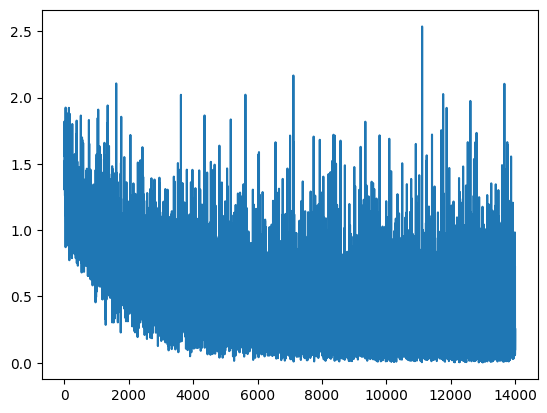

In [14]:
plt.plot(train_losses)

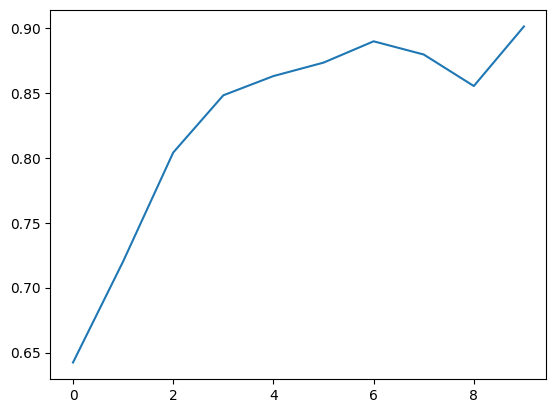

In [15]:
plt.plot(test_accuracy)

In [16]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [17]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 5047/5600 (0.9012)
{'acc_detail': tensor([0.8950, 0.9450, 0.8821, 0.8829], device='cuda:0'),
 'acc_unweighted': tensor(0.9013, device='cuda:0'),
 'acc_weighted': tensor(0.9013, device='cuda:0'),
 'f1s_detail': tensor([0.8808, 0.9096, 0.9230, 0.8924], device='cuda:0'),
 'f1s_unweighted': tensor(0.9015, device='cuda:0'),
 'f1s_weighted': tensor(0.9015, device='cuda:0'),
 'precision_detail': tensor([0.8671, 0.8767, 0.9679, 0.9022], device='cuda:0'),
 'recall_detail': tensor([0.8950, 0.9450, 0.8821, 0.8829], device='cuda:0'),
 'rocauc': tensor(0.9864, device='cuda:0'),
 'rocauc_detail': tensor([0.9800, 0.9889, 0.9920, 0.9846], device='cuda:0'),
 'uar': tensor(0.9013, device='cuda:0'),
 'wap': tensor(0.9035, device='cuda:0')}


tensor([[1253,   49,    7,   91],
        [  33, 1323,   23,   21],
        [  33,  110, 1235,   22],
        [ 126,   27,   11, 1236]], device='cuda:0')

In [18]:
model_path = '../models_esd4/esd4_m13mfcc_nohop_10epochs.pt' 
torch.save(model.state_dict(), model_path)